### Daytum Course: Spatial Data Analytics

### Basic Variography

Here's a simple workflow with some basic variogram calcuation with irregularly sampled data. This should help you get started with variogram caculation in subsurface modeling.

#### Spatial Continuity 

**Spatial Continuity** is the correlation between values over distance.

* No spatial continuity – no correlation between values over distance, random values at each location in space regardless of separation distance.

* Homogenous phenomenon have perfect spatial continuity, since all values as the same (or very similar) they are correlated. 

We need a statistic to quantify spatial continuity! A convenient method is the Semivariogram.

#### The Semivariogram

Function of difference over distance.

* The expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

where $z(\bf{u}_\alpha)$ and $z(\bf{u}_\alpha + \bf{h})$ are the spatial sample values at tail and head locations of the lag vector respectively.

* Calculated over a suite of lag distances to obtain a continuous function.

* the $\frac{1}{2}$ term converts a variogram into a semivariogram, but in practice the term variogram is used instead of semivariogram.
* We prefer the semivariogram because it relates directly to the covariance function, $C_x(\bf{h})$ and univariate variance, $\sigma^2_x$:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

Note the correlogram is related to the covariance function as:

\begin{equation}
\rho_x(\bf{h}) = \frac{C_x(\bf{h})}{\sigma^2_x}
\end{equation}

The correlogram provides of function of the $\bf{h}-\bf{h}$ scatter plot correlation vs. lag offset $\bf{h}$.  

\begin{equation}
-1.0 \le \rho_x(\bf{h}) \le 1.0
\end{equation}

#### Variogram Observations

The following are common observations for variograms that should assist with their practical use.

##### Observation \#1 - As distance increases, variability increase (in general).

This is common since in general, over greater distance offsets, there is often more difference between the head and tail samples.

In some cases, such as with spatial cyclicity of the hole effect variogram model the variogram may have negative slope over somelag distance intervals

Negative slopes at lag distances greater than half the data extent are often caused by too few pairs for a reliable variogram calculation

##### Observation \#2 - Calculated with over all possible pairs separated by lag vector, $\bf{𝐡}$.

We scan through the entire data set, searching for all possible pair combinations with all other data.  We then calculate the variogram as one half the expectation of squared difference between all pairs.

More pairs results in a more reliable measure.

##### Observation \#3 - Need to plot the sill to know the degree of correlation.

**Sill** is the variance, $\sigma^2_x$

Given stationarity of the variance, $\sigma^2_x$, and variogram $\gamma(\bf{h})$:

we can define the covariance function:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

The covariance measure is a measure of similarity over distance (the mirror image of the variogram as shown by the equation above).

Given a standardized distribution $\sigma^2_x = 1.0$, the covariance, $C_x(\bf{h})$, is equal to the correlogram, $\rho_x(\bf{h})$: 

\begin{equation}
\rho_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

##### Observation \#4 - The lag distance at which the variogram reaches the sill is know as the range.

At the range, knowing the data value at the tail location provides no information about a value at the head location of the lag distance vector.

##### Observation \#5 - The nugget effect, a discontinuity at the origin

Sometimes there is a discontinuity in the variogram at distances less than the minimum data spacing.  This is known as **nugget effect**.

The ratio of nugget / sill, is known as relative nugget effect (%). Modeled as a discontinuity with no correlation structure that at lags, $h \gt \epsilon$, an infinitesimal lag distance, and perfect correlation at $\bf{h} = 0$.
Caution when including nuggect effect in the variogram model as measurement error, mixing populations cause apparent nugget effect

This exercise demonstrates the semivariogram calculation with GeostatsPy. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize experimental semivariograms

#### Load the required libraries

The following code loads the required libraries.

In [3]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

We will also need some standard packages. These should have been installed with Anaconda 3.

In [6]:
import os                                               # to set current working directory 
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
import warnings
warnings.filterwarnings('ignore')

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [10]:
#os.chdir("c:/PGE383")                                   # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [13]:
#df = pd.read_csv("sample_data.csv")                     # read a .csv file in as a DataFrame
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data.csv") # load data from Dr. Pyrcz's GitHub respository
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head()                                               # we could also use this command for a table preview 

,X,Y,Facies,Porosity,Perm,AI
0,100.0,900.0,1.0,0.100187,1.363890,5110.699751
1,100.0,800.0,0.0,0.107947,12.576845,4671.458560
2,100.0,700.0,0.0,0.085357,5.984520,6127.548006
3,100.0,600.0,0.0,0.108460,2.446678,5201.637996
4,100.0,500.0,0.0,0.102468,1.952264,3835.270322


We will work by-facies, that is separating sand and shale facies and working with them separately.  This command extracts the sand and shale 'Facies" into new DataFrames for our analysis.

In [16]:
# Separate Sample Data by-facies - Deepcopy
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index() # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
df_sand.head()                                          # preview the sand only DataFrame

,index,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,1.0,0.100187,1.363890,5110.699751
1,8,100.0,100.0,1.0,0.137453,5.727603,5823.241783
2,9,200.0,900.0,1.0,0.137062,14.771314,5621.146994
3,10,200.0,800.0,1.0,0.125984,10.675436,4292.700500
4,18,300.0,900.0,1.0,0.111516,27.999817,4183.466773


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The 'describe' command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

Let's look at and compare the sumamry statistics for sand and shale.

In [19]:
df_sand.describe().transpose()                          # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,162.0,117.981481,59.058816,0.000000,75.250000,117.500000,157.750000,260.000000
X,162.0,831.111111,238.857269,50.000000,800.000000,945.000000,975.000000,1005.000000
Y,162.0,526.987654,142.707797,100.000000,469.000000,509.000000,549.000000,939.000000
Facies,162.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Porosity,162.0,0.181001,0.037196,0.083842,0.155735,0.194823,0.207754,0.242298
Perm,162.0,293.798999,399.989890,0.381032,31.996547,155.888123,385.177730,2642.999829
AI,162.0,3441.701689,969.924695,1844.166880,2748.296631,3179.596509,3998.567914,6197.834381


In [21]:
df_shale.describe().transpose()                         # summary table of shale only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,99.0,149.666667,93.588330,1.000000,41.500000,201.000000,225.500000,259.000000
X,99.0,300.444444,196.365820,40.000000,201.000000,231.000000,300.000000,970.000000
Y,99.0,425.111111,183.665784,29.000000,376.000000,416.000000,456.000000,989.000000
Facies,99.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Porosity,99.0,0.100212,0.014483,0.058871,0.091902,0.101987,0.109846,0.141657
Perm,99.0,3.568463,6.782476,0.033611,0.723788,1.530878,3.743835,52.500870
AI,99.0,5450.493543,728.871517,3595.586977,4897.828718,5570.604405,5951.816775,7881.898531


The facies have strong differences in their summary statistics.

Let's transform the data grouped overall both facies (sand and shale) and separated by facies to normal score values (Gaussian distributed with a mean of 0.0 and variance of 1.0). This is required for sequential Gaussian simulation (common target for our variogram models) and the Gaussian transform assists with outliers and provides more interpretable variograms. 

Let's look at the inputs for the GeostatsPy nscore program.  Note the output include an ndarray with the transformed values (in the same order as the input data in Dataframe 'df' and column 'vcol'), and the transformation table in original values and also in normal score values. 

In [24]:
geostats.nscore                                         # see the input parameters required by the nscore function

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

The following command will transform the Porosity and Permeabilty to standard normal. Note: we perform the transform for porsity and permeability and for each for the cases of:

1. all facies together
2. sand facies only
3. shale facies only

In [27]:
#Transform to Gaussian by Facies
df['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity 
df_sand['NPor'], tvPorSand, tnsPorSand = geostats.nscore(df_sand, 'Porosity')  # nscore transform for sand facies porosity 
df_shale['NPor'], tvPorShale, tnsPorShale = geostats.nscore(df_shale, 'Porosity')  # nscore transform for shale facies porosity
df['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df, 'Perm')  # nscore transform for all facies permeability
df_sand['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df_sand, 'Perm')  # nscore transform for sand facies permeability
df_shale['NPerm'], tvPermShale, tnsPermShale = geostats.nscore(df_shale, 'Perm')  # nscore transform for shale facies permeability

Let's look at a previous of one of the DataFrames to make sure that we now have the normal score porosity and permeability.

In [30]:
df_sand.head()                                          # preview sand DataFrame with nscore transforms

,index,X,Y,Facies,Porosity,Perm,AI,NPor,NPerm
0,0,100.0,900.0,1.0,0.100187,1.363890,5110.699751,-2.158819,-2.158819
1,8,100.0,100.0,1.0,0.137453,5.727603,5823.241783,-0.817609,-1.468475
2,9,200.0,900.0,1.0,0.137062,14.771314,5621.146994,-0.839418,-0.955141
3,10,200.0,800.0,1.0,0.125984,10.675436,4292.700500,-1.031153,-1.237102
4,18,300.0,900.0,1.0,0.111516,27.999817,4183.466773,-1.621370,-0.694044


That looks good! One way to check is to see if the relative magnitudes of the normal score transformed values match the original values.  e.g. that the normal score transform of 0.10 porosity normal score is less than the normal score transform of 0.14 porsity.  Also, the normal score transform of values close to the mean value should be close to 0.0 

Let's also check the original and transformed sand and shale porosity distributions.

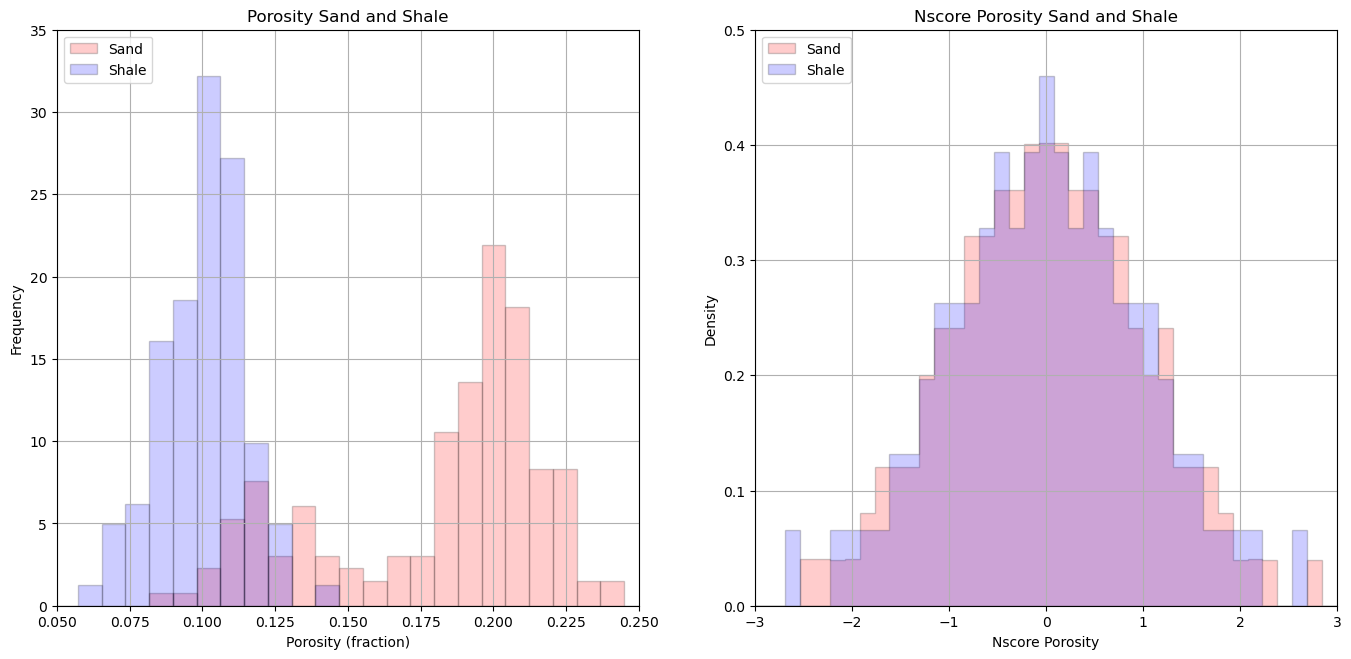

In [33]:
plt.subplot(121)                                        # plot original sand and shale porosity histograms
plt.hist(df_sand['Porosity'], facecolor='red',bins=np.linspace(0.0,0.4,50),alpha=0.2,density=True,edgecolor='black',label='Sand')
plt.hist(df_shale['Porosity'], facecolor='blue',bins=np.linspace(0.0,0.4,50),alpha=0.2,density=True,edgecolor='black',label = 'Shale')
plt.xlim([0.05,0.25]); plt.ylim([0,35.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Sand and Shale')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot nscore transformed sand and shale histograms
plt.hist(df_sand['NPor'], facecolor='red',bins=np.linspace(-3.0,3.0,40),histtype="stepfilled",alpha=0.2,density=True,cumulative=False,edgecolor='black',label='Sand')
plt.hist(df_shale['NPor'], facecolor='blue',bins=np.linspace(-3.0,3.0,40),histtype="stepfilled",alpha=0.2,density=True,cumulative=False,edgecolor='black',label='Shale')
plt.xlim([-3.0,3.0]); plt.ylim([0,0.50])
plt.xlabel('Nscore Porosity'); plt.ylabel('Density'); plt.title('Nscore Porosity Sand and Shale')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

The normal score transform has correctly transformed the porosity over sand and shale facies to standard normal.  Let's plot the location maps of normal score transforms of porosity and permeability for all facies, sand facies and shale facies.

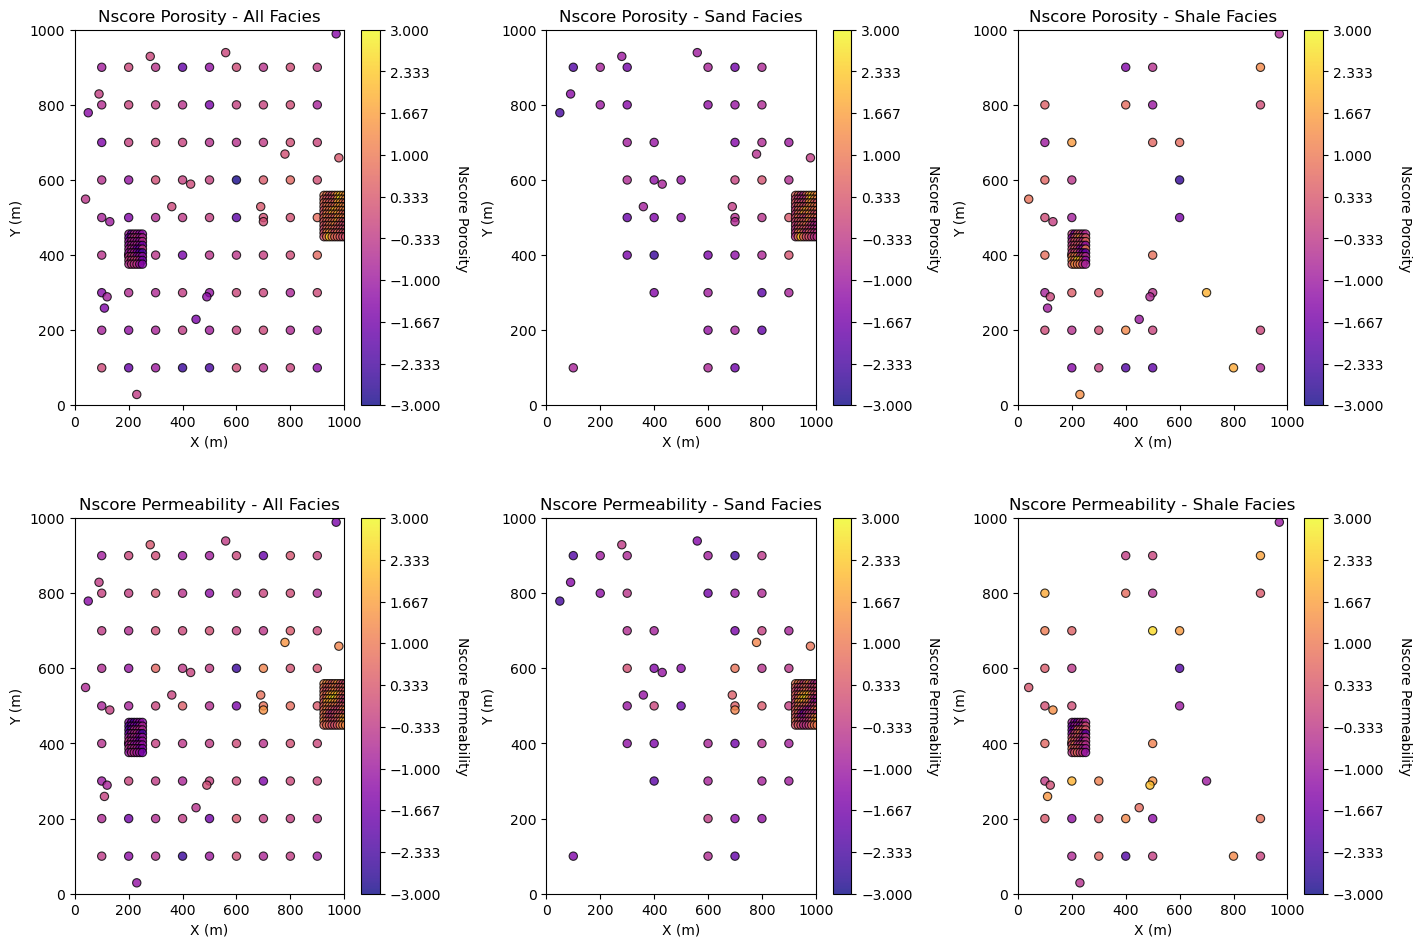

In [36]:
cmap = plt.cm.plasma                    # color map
plt.subplot(231)
GSLIB.locmap_st(df,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(232)
GSLIB.locmap_st(df_sand,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - Sand Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(233)
GSLIB.locmap_st(df_shale,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - Shale Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(234)
GSLIB.locmap_st(df,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(235)
GSLIB.locmap_st(df_sand,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - Sand Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(236)
GSLIB.locmap_st(df_shale,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - Shale Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.4, hspace=0.3)
plt.show()

Let's see what the parameters are for the gamv, irregular data, experimental variogram calculation program.

In [39]:
geostats.gamv                                           # see the input parameters required by the gamv function

<function geostatspy.geostats.gamv(df, xcol, ycol, vcol, tmin, tmax, xlag, xltol, nlag, azm, atol, bandwh, isill)>

We can use the location maps to help determine good variogram calculation parameters.

We are ready to calculate variogram! Let's calculate isotropic variograms for the transformed normal score porosity and permeability for sand, shale and mixed (without separating sand and shale).  Some information on the parameters that I chose:

```p
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 50.0; nlag = 7; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1
```
* tmin, tmax are trimming limits - set to have no impact, no need to filter the data
* lag_dist, lag_tol are the lag distance, lag tolerance - set based on the common data spacing (100m) and tolerance as 100% of lag distance for additonal smoothing
* nlag is number of lags - set to extend just past 50 of the data extent
* bandh is the horizontal band width - set to have no effect
* azi is the azimuth -  it has not effect since we set atol, the azimuth tolerance, to 90.0
* isill is a boolean to standardize the distribution to a variance of 1 - it has no effect since the nscore transform sets the variance to 1.0

Let's try running these variograms and visualizing them.

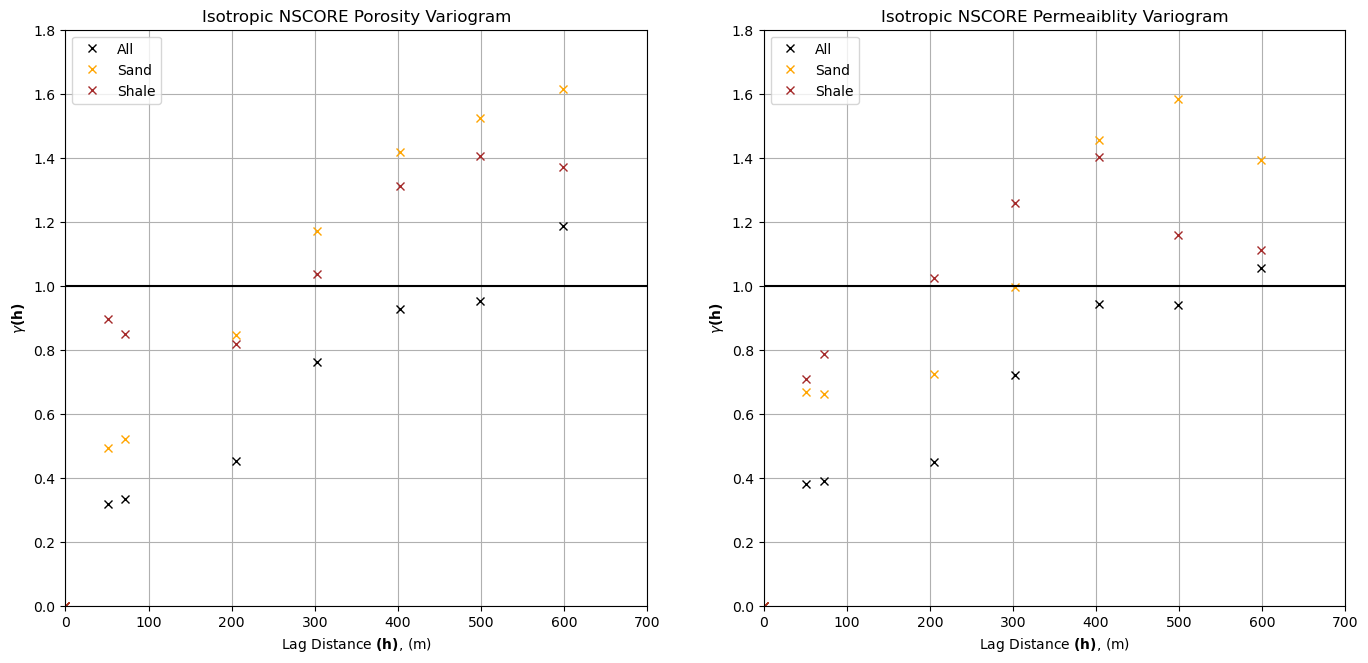

In [42]:
# Calculate Sample Data Isotropic Variograms
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, por_sand_gamma, por_sand_npair = geostats.gamv(df_sand,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag, por_shale_gamma, por_shale_npair = geostats.gamv(df_shale,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag, por_gamma, por_npair = geostats.gamv(df,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

lag, perm_sand_gamma, perm_sand_npair = geostats.gamv(df_sand,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag, perm_shale_gamma, perm_shale_npair = geostats.gamv(df_shale,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag, perm_gamma, perm_npair = geostats.gamv(df,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

plt.subplot(121)
plt.plot(lag,por_gamma,'x',color = 'black',label = 'All')
plt.plot(lag,por_sand_gamma,'x',color = 'orange',label = 'Sand')
plt.plot(lag,por_shale_gamma,'x',color = 'brown',label = 'Shale')
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)
plt.plot(lag,perm_gamma,'x',color = 'black',label = 'All')
plt.plot(lag,perm_sand_gamma,'x',color = 'orange',label = 'Sand')
plt.plot(lag,perm_shale_gamma,'x',color = 'brown',label = 'Shale')
plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Permeaiblity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

The experiental variograms have some interesting features:

* the range of the sand porosity and permeability is greater than the shale porosity and permeability range
* although the shale short range experimental points may be nosy due to sparce shale data

There is much more that you could try out, e.g. direction variograms.
 
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>